In [1]:
import nltk
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [2]:
class GetFormattedDataset:
    def __init__(self):
        dataset = nltk.corpus.treebank.tagged_sents(tagset='universal')
        train_set, test_set = train_test_split(dataset, test_size=0.15, random_state=42)
        train_set, dev_set = train_test_split(dataset, test_size=0.15, random_state=42)
        self.dataset = dict()
        self.dataset["x_train"] = [[d[0].lower() for d in data] for data in train_set]
        self.dataset["y_train"] = [[d[1] for d in data] for data in train_set]
        self.dataset["x_dev"] = [[d[0].lower() for d in data] for data in dev_set]
        self.dataset["y_dev"] = [[d[1] for d in data] for data in dev_set]
        self.dataset["x_test"] = [[d[0].lower() for d in data] for data in test_set]
        self.dataset["y_test"] = [[d[1] for d in data] for data in test_set]
        self.vocab = set([word for sentence in self.dataset["x_train"] for word in sentence])
        self.tags = set([tag for sentence in self.dataset["y_train"] for tag in sentence])

data_dict = GetFormattedDataset()

In [3]:
# Viterbi Algorithm
class Viterbi:
    def __init__(self, data_dict: GetFormattedDataset):
        self.data_dict = data_dict
        self.START = "<s>"
        self.UNKNOWN = "<unk>"
        self.emission_matrix = {w: {t: 0 for t in self.data_dict.tags} for w in self.data_dict.vocab}
        self.emission_matrix[self.UNKNOWN] = {t: 0 for t in self.data_dict.tags}
        self.transition_matrix = {t1: {t2: 0 for t2 in self.data_dict.tags} for t1 in self.data_dict.tags}
        self.transition_matrix[self.START] = {t: 0 for t in self.data_dict.tags}
        self.tag_count = dict()

    def __fill_tag_count(self):
        self.tag_count = {k: 0 for k in self.data_dict.tags}
        self.tag_count[self.START] = 0
        for sentence_tags in tqdm(self.data_dict.dataset["y_train"], desc="tag count"):
            for tag in sentence_tags:
                self.tag_count[tag] += 1
            self.tag_count[self.START] += 1

    def __fill_emission_matrix(self, smoothing=True):
        for data_idx in tqdm(range(len(self.data_dict.dataset["x_train"])), desc="emission"):
            words = self.data_dict.dataset["x_train"][data_idx]
            tags = self.data_dict.dataset["y_train"][data_idx]
            for word, tag in zip(words, tags):
                self.emission_matrix[word][tag] += 1

        for tag in self.data_dict.tags:
            for word in self.data_dict.vocab:
                if smoothing:
                    self.emission_matrix[word][tag] = (self.emission_matrix[word][tag] + 1) / (self.tag_count[tag] + len(self.data_dict.vocab))
                    self.emission_matrix[self.UNKNOWN][tag] = (0 + 1) / (self.tag_count[tag] + len(self.data_dict.vocab))
                else:
                    self.emission_matrix[word][tag] = self.emission_matrix[word][tag] / self.tag_count[tag]
                    self.emission_matrix[self.UNKNOWN][tag] = 0

    def __fill_transition_matrix(self, smoothing=True):
        for sentence_tags in tqdm(self.data_dict.dataset["y_train"], desc="transition"):
            for i in range(0, len(sentence_tags) - 1):
                tag1 = sentence_tags[i]
                tag2 = sentence_tags[i + 1]
                self.transition_matrix[tag1][tag2] += 1
                if i == 0:
                    self.transition_matrix[self.START][tag1] += 1

        for tag1 in self.transition_matrix.keys():
            for tag2 in self.transition_matrix[tag1].keys():
                if smoothing:
                    self.transition_matrix[tag1][tag2] = (self.transition_matrix[tag1][tag2] + 1) / (self.tag_count[tag1] + len(self.data_dict.tags))
                else:
                    self.transition_matrix[tag1][tag2] = self.transition_matrix[tag1][tag2] / self.tag_count[tag1]

    def train(self):
        self.__fill_tag_count()
        self.__fill_transition_matrix()
        self.__fill_emission_matrix()

    def predict(self, sentence: list):  # Viterbi Algorithm
        viterbi = [{t: 0 for t in self.data_dict.tags} for w_idx in range(len(sentence))]
        back_pointer = [{t: 0 for t in self.data_dict.tags} for w_idx in range(len(sentence))]
        for tag in self.data_dict.tags:
            word = sentence[0]
            emission_prob = self.emission_matrix[self.UNKNOWN][tag] if word not in self.emission_matrix else self.emission_matrix[word][tag]
            viterbi[0][tag] = self.transition_matrix[self.START][tag] * emission_prob

        for word_idx in range(1, len(sentence)):
            word = sentence[word_idx]
            prev_word = sentence[word_idx - 1]
            for tag in self.data_dict.tags:
                viterbi[word_idx][tag] = 0
                for prev_tag in self.data_dict.tags:
                    emission_prob = self.emission_matrix[self.UNKNOWN][tag] if word not in self.emission_matrix else self.emission_matrix[word][tag]
                    new_viterbi = viterbi[word_idx - 1][prev_tag] * self.transition_matrix[prev_tag][tag] * emission_prob
                    if new_viterbi > viterbi[word_idx][tag]:
                        viterbi[word_idx][tag] = new_viterbi
                        back_pointer[word_idx][tag] = prev_tag

        last_tag_prob = 0
        for tag in self.data_dict.tags:
            if viterbi[-1][tag] >= last_tag_prob:
                last_tag_prob = viterbi[-1][tag]
                last_tag = tag

        best_tags = [last_tag]
        for word_idx in range(len(sentence) - 1, 0, -1):
            best_tags.append(back_pointer[word_idx][last_tag])
            last_tag = back_pointer[word_idx][last_tag]
        return list(reversed(best_tags))

    def evaluate(self):
        tp = 0
        total = 0
        for data_idx in tqdm(range(len(self.data_dict.dataset["x_test"]))):
            tags = self.predict(self.data_dict.dataset["x_test"][data_idx])
            for t_pred, t_true in zip(tags, self.data_dict.dataset["y_test"][data_idx]):
                total += 1
                if t_pred == t_true:
                    tp += 1
        return tp / total


viterbi = Viterbi(data_dict)
viterbi.train()
viterbi.evaluate()

tag count:   0%|          | 0/3326 [00:00<?, ?it/s]

transition:   0%|          | 0/3326 [00:00<?, ?it/s]

emission:   0%|          | 0/3326 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

0.9026159026159026

In [4]:
# Print Viterbi erros
for idx in range(len(data_dict.dataset["x_test"])):
    sentence = data_dict.dataset["x_test"][idx]
    if len(sentence) < 8:
        pred = viterbi.predict(data_dict.dataset["x_test"][idx])
        true = data_dict.dataset["y_test"][idx]
        if pred != true:
            print(sentence)
            print("pred:", pred)
            print("true:", true)


['fundamentalists', 'jihad']
pred: ['DET', 'NOUN']
true: ['NOUN', 'NOUN']
['he', 'was', 'previously', 'vice', 'president', '.']
pred: ['PRON', 'VERB', 'DET', 'NOUN', 'NOUN', '.']
true: ['PRON', 'VERB', 'ADV', 'NOUN', 'NOUN', '.']
['such', 'is', 'hardly', 'the', 'case', '.']
pred: ['DET', 'VERB', 'ADP', 'DET', 'NOUN', '.']
true: ['ADJ', 'VERB', 'ADV', 'DET', 'NOUN', '.']
['heiwado', 'co', '.', '-lrb-', 'japan', '-rrb-', '--']
pred: ['DET', 'NOUN', '.', '.', 'NOUN', '.', '.']
true: ['NOUN', 'NOUN', '.', '.', 'NOUN', '.', '.']
['preston', 'g.', 'foster', 'birmingham', ',', 'ala', '.']
pred: ['DET', 'NOUN', 'NOUN', 'NOUN', '.', 'NOUN', '.']
true: ['NOUN', 'NOUN', 'NOUN', 'NOUN', '.', 'NOUN', '.']
['mortgage-backed', 'issues']
pred: ['DET', 'NOUN']
true: ['NOUN', 'NOUN']
['it', 'rose', '7\\/8', 'to', '18', '1\\/4', '.']
pred: ['PRON', 'VERB', 'X', 'PRT', 'NUM', 'NUM', '.']
true: ['PRON', 'VERB', 'NUM', 'PRT', 'NUM', 'NUM', '.']
['champagne', 'and', 'dessert', 'followed', '.']
pred: ['NOUN',

In [5]:
# Neural Network Trainer Class
class Trainer:
    def __init__(self, data_dict: GetFormattedDataset, units=64, rnn="SimpleRNN") -> None:
        self.data_dict = data_dict
        self.rnn = rnn
        self.tokenizer = Tokenizer(num_words=15000, oov_token="[UNK]")
        self.tokenizer.fit_on_texts(data_dict.dataset["x_train"])
        self.tokenized_x_train = pad_sequences(self.tokenizer.texts_to_sequences(data_dict.dataset["x_train"]), maxlen=100, padding="post")
        self.tokenized_x_dev = pad_sequences(self.tokenizer.texts_to_sequences(data_dict.dataset["x_dev"]), maxlen=100, padding="post")
        self.tokenized_x_test = pad_sequences(self.tokenizer.texts_to_sequences(data_dict.dataset["x_test"]), maxlen=100, padding="post")

        self.tag_tokenizer = Tokenizer()
        self.tag_tokenizer.fit_on_texts(data_dict.dataset["y_train"])
        self.tokenized_y_train = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(data_dict.dataset["y_train"]), maxlen=100, padding="post"), num_classes = len(self.data_dict.tags) + 1)
        self.tokenized_y_dev = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(data_dict.dataset["y_dev"]), maxlen=100, padding="post"), num_classes = len(self.data_dict.tags) + 1)
        self.tokenized_y_test = to_categorical(pad_sequences(self.tag_tokenizer.texts_to_sequences(data_dict.dataset["y_test"]), maxlen=100, padding="post"), num_classes = len(self.data_dict.tags) + 1)

        self.model = self.build_model(units)
        self.history = None

    def build_model(self, units):
        rnn_map = {
            "SimpleRNN": tf.keras.layers.SimpleRNN(units, return_sequences=True),
            "GRU": tf.keras.layers.GRU(units, return_sequences=True),
            "LSTM": tf.keras.layers.LSTM(units, return_sequences=True),
        }
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=15000, output_dim=32, input_length=100),
            rnn_map[self.rnn],
            tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(len(self.data_dict.tags) + 1,
                                      activation='softmax')
            )
        ])
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, batch_size=128, epochs=50):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True
        )
        self.history = self.model.fit(
            self.tokenized_x_train, self.tokenized_y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(self.tokenized_x_dev, self.tokenized_y_dev),
            callbacks=[early_stopping],
        )

Epoch 1/40
52/52 [==============================] - 11s 158ms/step - loss: 1.0993 - accuracy: 0.7305 - val_loss: 0.7620 - val_accuracy: 0.7606
Epoch 2/40
52/52 [==============================] - 5s 104ms/step - loss: 0.6630 - accuracy: 0.7981 - val_loss: 0.6267 - val_accuracy: 0.8107
Epoch 3/40
52/52 [==============================] - 8s 148ms/step - loss: 0.5773 - accuracy: 0.8223 - val_loss: 0.5758 - val_accuracy: 0.8184
Epoch 4/40
52/52 [==============================] - 4s 79ms/step - loss: 0.5307 - accuracy: 0.8354 - val_loss: 0.5279 - val_accuracy: 0.8408
Epoch 5/40
52/52 [==============================] - 3s 63ms/step - loss: 0.4705 - accuracy: 0.8675 - val_loss: 0.4521 - val_accuracy: 0.8821
Epoch 6/40
52/52 [==============================] - 5s 102ms/step - loss: 0.3819 - accuracy: 0.9106 - val_loss: 0.3533 - val_accuracy: 0.9155
Epoch 7/40
52/52 [==============================] - 6s 114ms/step - loss: 0.2891 - accuracy: 0.9304 - val_loss: 0.2686 - val_accuracy: 0.9321
Epoch 8

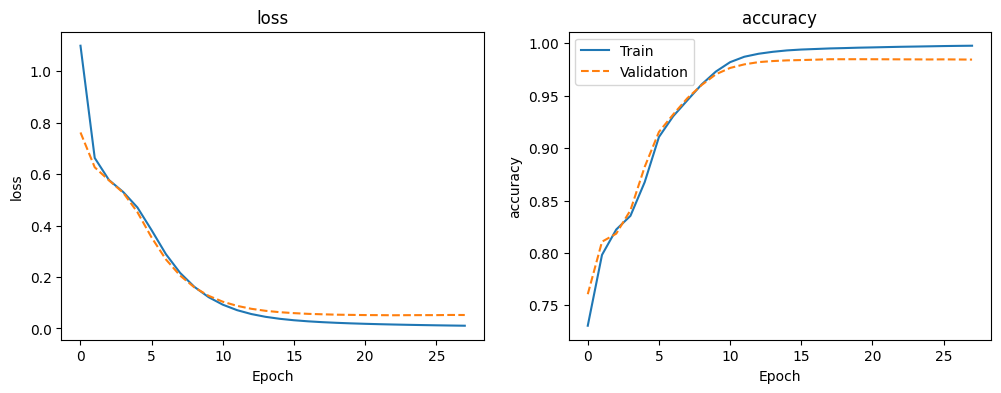

19/19 [==============================] - 0s 10ms/step - loss: 0.0515 - accuracy: 0.9847
Test Loss: 0.05146314948797226 Test Accuracy (w/ padding): 0.9847449064254761
19/19 [==============================] - 0s 9ms/step


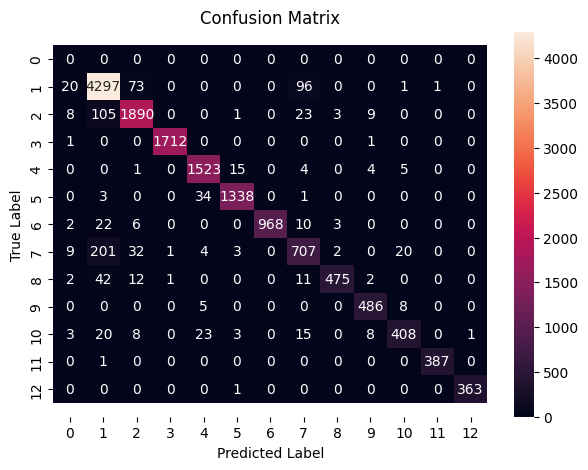

Test Accuracy (w/o padding): 0.9423724423724423


In [6]:
# Train using RNN
rnnTrainer = Trainer(data_dict, units=64)
rnnTrainer.train(batch_size=64, epochs=40)


# Plot Figures
fig = plt.figure(figsize=(12, 4))
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
    plt.subplot(1, 2, n+1)
    plt.plot(rnnTrainer.history.epoch, rnnTrainer.history.history[metric], label='Train')
    plt.plot(rnnTrainer.history.epoch, rnnTrainer.history.history[f"val_{metric}"], linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
plt.legend()
plt.show()




[test_loss, test_acc] = rnnTrainer.model.evaluate(rnnTrainer.tokenized_x_test, rnnTrainer.tokenized_y_test)
print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)

def flatten(t):
    return [item for sublist in t for item in sublist]

test_preds = np.argmax(rnnTrainer.model.predict(rnnTrainer.tokenized_x_test), axis=-1)
test_preds = flatten([test_preds[i][:len(data_dict.dataset["x_test"][i])] for i in range(len(test_preds))])
y_test = np.argmax(rnnTrainer.tokenized_y_test, axis=-1)
y_test = flatten([y_test[i][:len(data_dict.dataset["y_test"][i])] for i in range(len(y_test))])
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))

Epoch 1/40
52/52 [==============================] - 9s 93ms/step - loss: 1.4229 - accuracy: 0.7171 - val_loss: 0.7098 - val_accuracy: 0.7426
Epoch 2/40
52/52 [==============================] - 4s 83ms/step - loss: 0.6521 - accuracy: 0.7738 - val_loss: 0.6448 - val_accuracy: 0.7903
Epoch 3/40
52/52 [==============================] - 6s 121ms/step - loss: 0.5989 - accuracy: 0.8119 - val_loss: 0.5782 - val_accuracy: 0.8131
Epoch 4/40
52/52 [==============================] - 4s 84ms/step - loss: 0.5276 - accuracy: 0.8223 - val_loss: 0.5018 - val_accuracy: 0.8336
Epoch 5/40
52/52 [==============================] - 4s 85ms/step - loss: 0.4203 - accuracy: 0.8780 - val_loss: 0.3509 - val_accuracy: 0.9234
Epoch 6/40
52/52 [==============================] - 6s 123ms/step - loss: 0.2628 - accuracy: 0.9384 - val_loss: 0.2115 - val_accuracy: 0.9515
Epoch 7/40
52/52 [==============================] - 4s 83ms/step - loss: 0.1598 - accuracy: 0.9625 - val_loss: 0.1381 - val_accuracy: 0.9660
Epoch 8/40


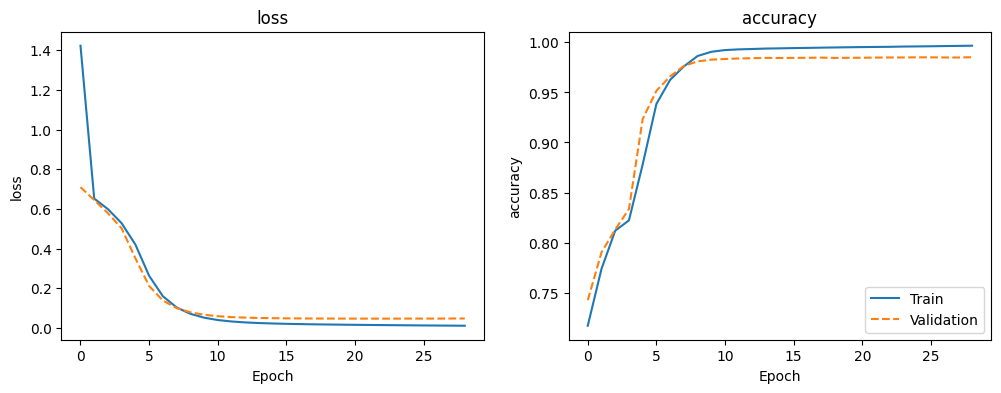

19/19 [==============================] - 1s 25ms/step - loss: 0.0467 - accuracy: 0.9848
Test Loss: 0.0467250682413578 Test Accuracy (w/ padding): 0.9848469495773315
19/19 [==============================] - 1s 15ms/step


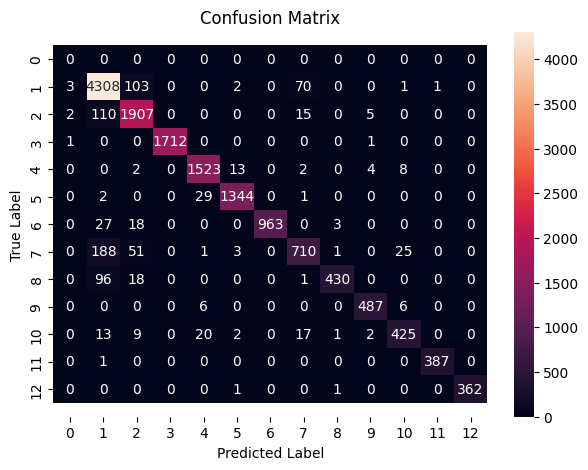

Test Accuracy (w/o padding): 0.9426314426314426


In [7]:
# Traing using GRU
gruTrainer = Trainer(data_dict, units=64, rnn="GRU")
gruTrainer.train(batch_size=64, epochs=40)




# Plot Figures
fig = plt.figure(figsize=(12, 4))
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
    plt.subplot(1, 2, n+1)
    plt.plot(gruTrainer.history.epoch, gruTrainer.history.history[metric], label='Train')
    plt.plot(gruTrainer.history.epoch, gruTrainer.history.history[f"val_{metric}"], linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
plt.legend()
plt.show()




[test_loss, test_acc] = gruTrainer.model.evaluate(gruTrainer.tokenized_x_test, gruTrainer.tokenized_y_test)
print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)

def flatten(t):
    return [item for sublist in t for item in sublist]

test_preds = np.argmax(gruTrainer.model.predict(gruTrainer.tokenized_x_test), axis=-1)
test_preds = flatten([test_preds[i][:len(data_dict.dataset["x_test"][i])] for i in range(len(test_preds))])
y_test = np.argmax(gruTrainer.tokenized_y_test, axis=-1)
y_test = flatten([y_test[i][:len(data_dict.dataset["y_test"][i])] for i in range(len(y_test))])
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))

Epoch 1/40
52/52 [==============================] - 8s 102ms/step - loss: 1.2399 - accuracy: 0.7333 - val_loss: 0.7740 - val_accuracy: 0.7467
Epoch 2/40
52/52 [==============================] - 7s 127ms/step - loss: 0.7099 - accuracy: 0.7654 - val_loss: 0.6980 - val_accuracy: 0.7620
Epoch 3/40
52/52 [==============================] - 5s 93ms/step - loss: 0.6548 - accuracy: 0.7805 - val_loss: 0.6556 - val_accuracy: 0.8050
Epoch 4/40
52/52 [==============================] - 7s 127ms/step - loss: 0.6154 - accuracy: 0.8153 - val_loss: 0.6125 - val_accuracy: 0.8134
Epoch 5/40
52/52 [==============================] - 5s 104ms/step - loss: 0.5784 - accuracy: 0.8195 - val_loss: 0.5810 - val_accuracy: 0.8218
Epoch 6/40
52/52 [==============================] - 5s 92ms/step - loss: 0.5547 - accuracy: 0.8253 - val_loss: 0.5572 - val_accuracy: 0.8230
Epoch 7/40
52/52 [==============================] - 7s 130ms/step - loss: 0.5290 - accuracy: 0.8288 - val_loss: 0.5308 - val_accuracy: 0.8282
Epoch 8/

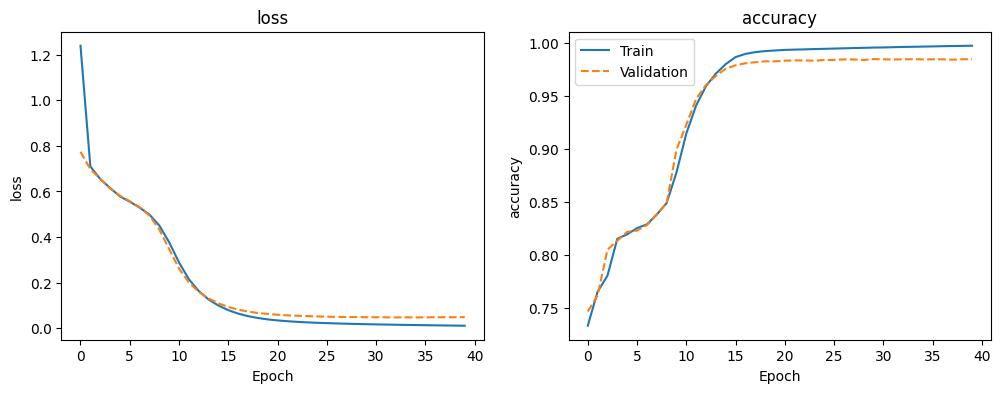

19/19 [==============================] - 0s 18ms/step - loss: 0.0467 - accuracy: 0.9844
Test Loss: 0.04672561213374138 Test Accuracy (w/ padding): 0.9844217896461487
19/19 [==============================] - 1s 20ms/step


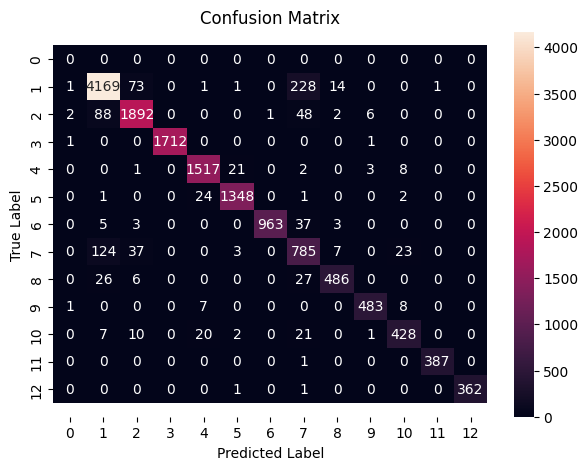

Test Accuracy (w/o padding): 0.940947940947941


In [8]:
# Train using LSTM
lstmTrainer = Trainer(data_dict, units=64, rnn="LSTM")
lstmTrainer.train(batch_size=64, epochs=40)



# Plot Figures
fig = plt.figure(figsize=(12, 4))
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
    plt.subplot(1, 2, n+1)
    plt.plot(lstmTrainer.history.epoch, lstmTrainer.history.history[metric], label='Train')
    plt.plot(lstmTrainer.history.epoch, lstmTrainer.history.history[f"val_{metric}"], linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(metric)
plt.legend()
plt.show()




[test_loss, test_acc] = lstmTrainer.model.evaluate(lstmTrainer.tokenized_x_test, lstmTrainer.tokenized_y_test)
print("Test Loss:", test_loss, "Test Accuracy (w/ padding):", test_acc)

def flatten(t):
    return [item for sublist in t for item in sublist]

test_preds = np.argmax(lstmTrainer.model.predict(lstmTrainer.tokenized_x_test), axis=-1)
test_preds = flatten([test_preds[i][:len(data_dict.dataset["x_test"][i])] for i in range(len(test_preds))])
y_test = np.argmax(lstmTrainer.tokenized_y_test, axis=-1)
y_test = flatten([y_test[i][:len(data_dict.dataset["y_test"][i])] for i in range(len(y_test))])
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("Test Accuracy (w/o padding):", accuracy_score(y_test, test_preds))